In [62]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA, KernelPCA
import optuna

import sys
sys.path.append("../") # go to parent dir

from src.debiasing import DebiasingPCA
from src.debiasing import DebiasingKernelPCA
from src.debiasing.utils import get_design_matrix

In [63]:
data = pd.read_csv("../data/CoLA/mixed_dev_embeddings.tsv", sep="\t")
data = data.sort_values(by='defining set id')
X = data.iloc[:, 3:771].to_numpy()
X_index = data['defining set id'].to_numpy()

Text(0.5, 0, 'the number of components')

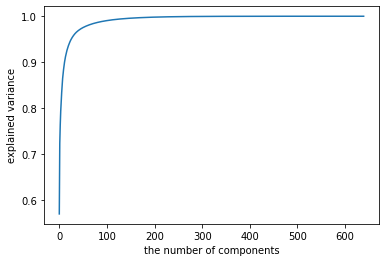

In [64]:
# data visualization
eigvals = PCA().fit(X).explained_variance_
explained_var = np.cumsum(eigvals) / np.sum(eigvals)
plt.plot(explained_var)
plt.ylabel('explained variance')
plt.xlabel('the number of components')

# PCA debiasing

In [65]:
debiaser = DebiasingPCA(n_components=3)
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [66]:
np.linalg.norm(X_debiased)

327.86928356926535

# Kernel PCA debiasing (by kernel ridge pre-imaging)

In [67]:
np.linalg.norm(X)

426.1726765040533

### Unsuccessful case (Learn pre-image of bias subspace by min || Phi(w) - Proj (Phi(w))||)

In [68]:
debiaser = DebiasingKernelPCA(n_components=3, kernel="rbf")
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [69]:
np.linalg.norm(X_debiased)

63.74915566837997

### Unsuccessful case (Learn pre-image of bias subspace by min || Phi(w - m) - Proj (Phi(w - m))||)

In [70]:
DX = get_design_matrix(X_index)
X_diff = DX @ X
kpca = KernelPCA(n_components=3, kernel="rbf", gamma=0.14, fit_inverse_transform=True)
kpca.fit(X_diff)
X_bias = kpca.inverse_transform(kpca.transform(X))
X_debiased = X - X_bias

In [71]:
np.linalg.norm(X_debiased)

425.87166574536064

# Kernel PCA

In [72]:
import scipy
from sklearn.exceptions import NotFittedError
#from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import pairwise_kernels
from sklearn.utils.extmath import svd_flip
from sklearn.utils.validation import _check_psd_eigenvalues

import optuna

from src.debiasing.utils import get_design_matrix, is_sorted
# from src.debiasing.kernel_pca import CenteredKernelPCA as KPCA

In [73]:
def RBF(X, Y=None, grad=False):
    gamma = 1. / X.shape[-1]
    Y = X if Y is None else Y
    if grad:
        K = torch.exp(-gamma*torch.sum((X-Y)**2, axis=-1))
    else:
        X = np.expand_dims(X, 1)
        Y = np.expand_dims(Y, 0)
        K = np.exp(-gamma*np.sum((X-Y)**2, axis=-1))
    return K

In [74]:
class DebiasingKernelPCA:
    """Kernel PCA with mean-centering in feature space within each group.
    
    The design of this class is mostly based on sklearn.decomposition.KernelPCA.  
    
    Parameters
    ----------
    n_components : int, default=None
        Number of components. If None, all non-zero components are kept.    
    kernel: string or callable
        The kernel to use when calculating kernel between instances in a
        feature array. Valid string values for kernel are:
        ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
        which must be one of the kernels in sklearn.pairwise.PAIRWISE_KERNEL_FUNCTIONS.
        If callable is passed, kernel must have following arguments:
        - X: array [n_sample_a, n_features]
        - Y: array [n_sample_b, n_features]
        - torch: bool, whose Default is set `False`.
        When `torch` is set `True`, the kernel must return torch.Tensor which is differentiable w.r.t. X and Y.   
    coef0 : float, default=1
        Independent term in poly and sigmoid kernels.
        Ignored by other kernels.
    kernel_params : mapping of string to any, default=None
        Parameters (keyword arguments) and values for kernel passed as
        callable object. Ignored by other kernels.
    alpha : int, default=1.0
        Hyperparameter of the ridge regression that learns the
        inverse transform.
    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
        
    Attributes
    ----------
    lambdas_ : array, (n_components,)
        Eigenvalues of the centered kernel matrix in decreasing order.
        If `n_components` and `remove_zero_eig` are not set,
        then all values are stored.
    alphas_ : array, (n_samples, n_components)
        Eigenvectors of the centered kernel matrix. If `n_components` and
        `remove_zero_eig` are not set, then all components are stored.
    dual_coef_ : array, (n_samples, n_features)
        Inverse transform matrix. Only available when
        ``fit_inverse_transform`` is True.
    X_transformed_fit_ : array, (n_samples, n_components)
        Projection of the fitted data on the kernel principal components.
        Only available when ``fit_inverse_transform`` is True.
    X_fit_ : (n_samples, n_features)
        The data used to fit the model. If `copy_X=False`, then `X_fit_` is
        a reference. This attribute is used for the calls to transform.

    Remark
    ------
    The design of this class is based on the sklearn.decomposition.KernelPCA.
    """
    def __init__(self, n_components, *, kernel="linear", inv_kernel=None, 
                 gamma=None, degree=3, coef0=1, kernel_params=None,
                 alpha=1.0, n_jobs=None):
        self.n_components = n_components
        self.kernel = kernel
        self.inv_kernel = kernel if inv_kernel is None else inv_kernel
        self.kernel_params = kernel_params
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.X_fit_ = None

    def fit(self, X, X_index=None):
        """Fit grouped samples in X to extract bias subspace.

        Parameters
        ----------
        X: array [n_samples, n_features]
        X_index: array: [n_samples]
            `X_index` indicates the group to which specific sample belongs to.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        K = _centered_kernel(X=X, X_index=X_index, kernel=self.kernel)

        if self.n_components is None:
            n_components = K.shape[0]
        else:
            n_components = min(K.shape[0], self.n_components)

        # compute eigenvectors
        if K.shape[0] > 200 and n_components < 10:  # use ARPACK
            # initialize with [-1,1] as in ARPACK
            v0 = np.random.RandomState(0).uniform(-1, 1, K.shape[0])
            self.lambdas_, self.alphas_ = scipy.sparse.linalg.eigsh(K, n_components,
                                                which="LA",
                                                tol=0,
                                                maxiter=None,
                                                v0=v0)
        else:
            self.lambdas_, self.alphas_ = scipy.linalg.eigh(
                K, eigvals=(K.shape[0] - n_components, K.shape[0] - 1))
        
        # make sure that the eigenvalues are ok and fix numerical issues
        self.lambdas_ = _check_psd_eigenvalues(self.lambdas_,
                                               enable_warnings=False)

        # flip eigenvectors' sign to enforce deterministic output
        self.alphas_, _ = svd_flip(self.alphas_,
                                   np.zeros_like(self.alphas_).T)

        # sort eigenvectors in descending order
        indices = self.lambdas_.argsort()[::-1]
        self.lambdas_ = self.lambdas_[indices]
        self.alphas_ = self.alphas_[:, indices]

        # remove eigenvectors with a zero eigenvalue (null space) if required
        mask_non_zero = self.lambdas_ > 1e-8
        if sum(mask_non_zero) < self.n_components:
            print("The effective number of the components was smaller than the given `n_components`."
                  "Please be careful about the dimension of the tranformed feature, as it is smaller than `n_components`.")
        self.alphas_ = self.alphas_[:, self.lambdas_ > 1e-8]
        self.lambdas_ = self.lambdas_[self.lambdas_ > 1e-8]
        
        self.X_fit_ = X
        self.X_fit_index_ = X_index
        
        self._fit_inverse_transform(X, None)

        return self

    def _fit_inverse_transform(self, X, X_index=None):
        
        X_transformed = self.transform(X)
        self.X_fit_inverse_ = X
        self.X_transformed_fit_inverse_ = X_transformed

        """
        # fit linear inversion
        K = _centered_kernel(X, X_index, self.X_fit_, self.X_fit_index_, self.kernel)
        A = K @ self.alphas_
        AA = A.T @ A
        B = scipy.linalg.solve(
            a = self.alpha * np.diag(self.lambdas_) + AA,
            b = AA, 
            sym_pos = True
        )
        C = np.eye(len(self.lambdas_)) - B
        D = (1. / self.alpha) * np.diag(1. / np.sqrt(self.lambdas_))
        self.linear_dual_coef_ = D @ C @ A.T @ X
        """
        
        # fit inversion
        K = _centered_kernel(X=X_transformed, kernel=self.inv_kernel)
        n_samples = K.shape[0]
        K.flat[::n_samples + 1] += self.alpha
        self.nonlinear_dual_coef_ = scipy.linalg.solve(K, X, sym_pos=True, overwrite_a=True)
        
        # This cannot fit grouped values
        # self.kernel_ridge = KernelRidge(alpha=self.alpha, kernel=self.inv_kernel).fit(X_transformed, X)
        
    def transform(self, X, X_index=None):
        """Transform X.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        
        Returns
        -------
        X_transformed : array-like, shape (n_samples, n_components)
        """
        assert self.X_fit_ is not None  # Fit the model first before using this method!
        K = _centered_kernel(X, X_index, self.X_fit_, self.X_fit_index_, self.kernel)
        X_transformed =  (K @ self.alphas_) @ np.diag(1. / np.sqrt(self.lambdas_))
        return X_transformed

    def inverse_transform(self, X_transformed):
        """Transform X back to original space using kernel ridge regression.
        
        Parameters
        ----------
        X_transformed : array-like, shape (n_samples, n_components)
        
        Returns
        -------
        X_new : array-like, shape (n_samples, n_features)
        
        References
        ----------
        "Learning to Find Pre-Images", G BakIr et al, 2004.
        """
        assert self.X_fit_ is not None  # Fit the model first before using this method!
        K = _centered_kernel(X=X_transformed, Y=self.X_transformed_fit_inverse_, kernel=self.inv_kernel)
        return K @ self.nonlinear_dual_coef_
        # return self.kernel_ridge.predict(X_transformed)
        
    def orthogonalize(self, X):
        
        assert callable(self.kernel)
        assert self.X_fit_ is not None  # Fit the model first before using this method!
        
        X = torch.tensor(X)
        X_orth = torch.tensor(X, requires_grad=True)
        
        optimizer, = torch.optim.SGD(lr=0.05, momentum=0, params=[X_orth]), 
        n_iter = 300
        for i in range(n_iter):
            optimizer.zero_grad()
            losses = self.orth_losses(X, X_orth)
            loss = torch.sum(losses)
            loss.backward()
            optimizer.step()
        
        return X_orth.detach().cpu().numpy()
    
    def orth_losses(self, X, X_orth):
        
        n_samples, n_features = X.shape
        n_train = self.X_fit_.shape[0]
        
        X_fit_ = torch.from_numpy(self.X_fit_)
        alphas = torch.from_numpy(self.alphas_)
        alphasT = torch.from_numpy(self.alphas_.T)
        lambdas_inv = torch.from_numpy(np.diag(1. / self.lambdas_))
        
        Koo = self.kernel(X=X_orth.reshape(n_samples, 1, n_features), grad=True).squeeze()
        Kox = self.kernel(
            X=X_orth.reshape(n_samples, 1, n_features), 
            Y=X.reshape(n_samples, 1, n_features), 
            grad=True
        ).squeeze()
        KoP = _centered_kernel(
            X=X_orth.reshape(n_samples, 1, n_features),
            Y=X_fit_.reshape(1, n_train, n_features),
            Y_index=self.X_fit_index_,
            kernel=self.kernel,
            grad=True
        ).squeeze()
        KPx = _centered_kernel(
            X=X_fit_.reshape(n_train, 1, n_features),
            X_index=self.X_fit_index_,
            Y=X.reshape(1, n_samples, n_features),
            kernel=self.kernel,
            grad=True
        ).squeeze()
        
        losses = Koo - 2. * Kox + 2. * KoP @ alphas @ lambdas_inv @ alphasT @ KPx
        return losses
        
        
    def debias(self, X, X_index=None, method="ridge"):
        """Debias the embeddings by reprojection of kernel PCA.
        
        Parameters
        ----------
        X: array [n_samples, n_features]
        method: "ridge" or "optimization"
            When the "ridge" is used, kernel ridge regression is used to approximate the pre-imaging. 
            For details, see the reference. When the "optimization" is used, optimization is used to 
            obtain the pre-image. In this case, the kernel must support the option `torch=True` so 
            that gradient-based optimization can be applied.
            
        References
        ----------
        "Learning to Find Pre-Images", G BakIr et al, 2004.
        """
        assert self.X_fit_ is not None  # Fit the model first before using this method!
        
        if method == "ridge":
            X_tr = self.transform(X, X_index)
            X_orth = X - self.inverse_transform(X_tr)
        elif method == "optimization":
            assert callable(self.kernel)
            X_orth = self.orthogonalize(X)
        return X_orth

def _centered_kernel(X, X_index=None, Y=None, Y_index=None, kernel="linear", filter_params=True, n_jobs=None, grad=False, **kwds):
    """Compute the group-mean-centered kernel between arrays X and Y.

    This method takes either a vector array and returns a kernel matrix. 
    For the mean centering of the kernel within each group, the index to which 
    each sample belongs to must be privided as ``X_index`` and ``Y_index``. 
    When there is a sample that does not belong to any group, its index 
    must be set ``nan``, and centering is not applied to the sample.

    Parameters
    ----------
    X : array [n_samples_a, n_features]
        A feature array which is sorted accoding to the group index. 
        Note that if the index of an sample is 'np.nan', the sample must come at the last of the array.  
    X_index: integer array [n_samples]
        A sorted array of indices to which samples in X belongs to. When a sample does 
        not belong to any group, its index must be ``np.nan``. 
    Y: array [n_samples_b, 1 + n_features]
        A second feature array which is sorted accoding to the group index. 
        Note that if the index of an sample is 'np.nan', the sample must come at the last of the array.  
    Y_index: integer array [n_samples]
        A sorted array of indices to which samples in Y belongs to. When a sample does 
        not belong to any group, its index must be ``np.nan``. 
    kernel: string or callable
        The kernel to use when calculating kernel between instances in a
        feature array. Valid string values for kernel are:
        ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
        which must be one of the kernels in sklearn.pairwise.PAIRWISE_KERNEL_FUNCTIONS.
        If callable is passed, kernel must have following arguments:
        - X: array [n_sample_a, n_features]                         if torch==False
             torch.Tensor [n_sample_a, 1 or n_sample_b, n_features] if torch==True 
        - Y: array [n_sample_b, n_features]                         if torch==False 
             torch.Tensor [1 or n_sample_a, n_sample_b, n_features] if torch==True 
        - torch: bool, whose Default is set `False`.
        When `torch` is set `True`, the kernel must return torch.Tensor which is differentiable w.r.t. X and Y.
    filter_params : boolean
        Whether to filter invalid parameters or not.
    n_jobs : int or None, optional (default=None)
        The number of jobs to use for the computation. This works by breaking
        down the pairwise matrix into n_jobs even slices and computing them in
        parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    **kwds : optional keyword parameters
        Any further parameters are passed directly to the kernel function.

    Returns
    -------
    K : array or torch.Tensor of shape [n_samples_a, n_samples_b]
        A mean-centered kernel matrix K such that K_{i, j} is the kernel between the
        ith and jth vectors of the given matrix X, if Y is None.
        If Y is not None, then K_{i, j} is the kernel between the ith array
        from X and the jth array from Y.

    """
    if isinstance(kernel, str):
        KXY = pairwise_kernels(X, Y, metric=kernel, filter_params=filter_params, n_jobs=n_jobs, **kwds)
    elif callable(kernel):
        KXY = kernel(X, Y, grad=grad)
    else:
        raise ValueError("An invalid value is given as the argument `kernel`. "
                         "`kernel` should be either string or callable.")
    
    if Y is None:
        Y = X
        Y_index = X_index
        
    X_index = _fix_index_if_none(X, X_index)
    Y_index = _fix_index_if_none(Y, Y_index)
    
    assert is_sorted(X_index)
    assert is_sorted(Y_index)
    
    DX = get_design_matrix(X_index)
    DY = get_design_matrix(Y_index)

    if grad:
        DX = _to_torch_sparse(DX)
        DY = _to_torch_sparse(DY)
        KYX = KXY.transpose(0,1)
        KXY_centered = torch.sparse.mm(DX, torch.sparse.mm(DY, KYX).transpose(0,1))  
    else:
        KXY_centered = DX @ KXY @ DY
    return KXY_centered

def _fix_index_if_none(X, X_index):
    if X_index is None:
        return np.full(shape=X.squeeze().shape[0], fill_value=np.nan)
    else:
        return X_index

def _to_torch_sparse(M):
    """
    input: M is Scipy sparse matrix
    output: pytorch sparse tensor in GPU 
    """
    M = M.tocoo().astype(np.float64)
    indices = torch.from_numpy(np.vstack((M.row, M.col))).long()#.cuda()
    values = torch.from_numpy(M.data)#.cuda()
    shape = torch.Size(M.shape)
    M_torch = torch.sparse_coo_tensor(indices, values, shape)#, device=torch.device('cuda'))
    return M_torch
    
def _test_centered_kernel():
    
    D = 500
    N = 1000
    N_grouped = 900
    N_nan = N - N_grouped
    num_groups = 100
    
    # X contains groups of various size and non-centered samples
    X = np.random.randn(N * D).reshape(N, D)
    X_index = np.concatenate([
        np.repeat(np.arange(num_groups), 2),  
        np.random.randint(0, num_groups, N_grouped - 2*num_groups),
        np.full([N_nan], np.nan)
    ])
    X_index.sort()
    
    
    # Y only contains non-centered samples
    Y = np.random.randn(N * D).reshape(N, D)
    Y_index = np.array([np.nan] * N)
    
    Kxx = _centered_kernel(X, X_index, X, X_index, kernel="rbf")
    Kxx_ = _centered_kernel(X, X_index, kernel="rbf")
    assert np.allclose(Kxx, Kxx_)
    assert np.allclose(Kxx, Kxx.T)
    eigvals = np.linalg.eigvalsh(Kxx)
    assert np.all(-1e-8 < eigvals)  # Kernel matrix must be positive definite.
    assert np.sum(1e-8 < eigvals) == (N - num_groups)  # The effective rank of the matrix should be (N - num_groups).
    
    Kxy = _centered_kernel(X, X_index, Y, Y_index, kernel="rbf")
    Kyx = _centered_kernel(Y, Y_index, X, X_index, kernel="rbf")
    assert np.allclose(Kxy, Kyx.T)  # Kernel matrix must be symmetric. 
    
if __name__ == "__main__":
    _test_centered_kernel()

In [75]:
m = DebiasingKernelPCA(n_components=2, kernel=RBF)
m.fit(X, X_index)
X_tr = m.transform(X)
X_reproj = m.debias(X, method="ridge")

In [76]:
np.linalg.norm(X_reproj)

75.98850977617846

In [77]:
np.linalg.norm(X)

426.1726765040533

In [78]:
np.linalg.norm(X - X_reproj)

417.2504621787989

# Make sure that implementation is consistent with sklearn's KernelPCA

Minor difference in the reconstruction error is due to the mean centering in the KernelPCA.

In [79]:
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA, PCA
toy_data = load_digits()['data']
x_train = toy_data[:1300]
x_test = toy_data[1300:]

Reprojection Error of <class '__main__.DebiasingKernelPCA'>: 406.63554419120555
Reprojection Error of <class '__main__.DebiasingKernelPCA'>: 1378.516355683355
Reprojection Error of <class '__main__.DebiasingKernelPCA'>: 1369.6930247389425
Reprojection Error of <class '__main__.DebiasingKernelPCA'>: 770.4399333320856


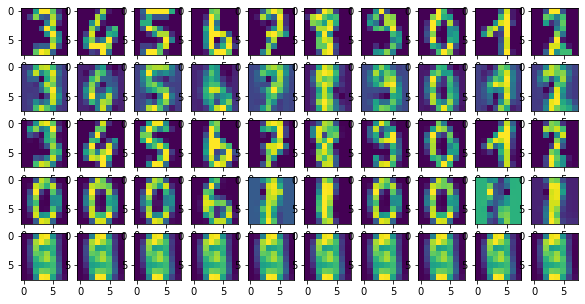

In [80]:
models = [
    #PCA(n_components=10), 
    #KernelPCA(n_components=10, fit_inverse_transform=True, kernel="rbf"), 
    DebiasingKernelPCA(n_components=10, kernel="linear", inv_kernel="linear"),
    DebiasingKernelPCA(n_components=10, kernel="linear", inv_kernel="rbf"),
    DebiasingKernelPCA(n_components=10, kernel="rbf", inv_kernel="linear"),
    DebiasingKernelPCA(n_components=10, kernel="rbf", inv_kernel="rbf")
]
N = len(models)+1
def plot_digits(x, N_comparison, n):
    for i in range(10):
        plt.subplot(N_comparison, 10, 1 + n * 10 + i)
        plt.imshow(x[i, :].reshape([8, 8]))

plt.figure(figsize=[10, N])
plot_digits(x_test, N, 0)
for n, model in enumerate(models):
    m = model.fit(x_train)
    x_transformed = m.transform(x_test)
    x_reprojected = m.inverse_transform(x_transformed)
    print("Reprojection Error of {}: {}".format(model.__class__, np.linalg.norm(x_test - x_reprojected)))
    plot_digits(x_reprojected, N, n+1)

Reprojection Error of <class 'sklearn.decomposition._kernel_pca.KernelPCA'>: 1101.7898059173995


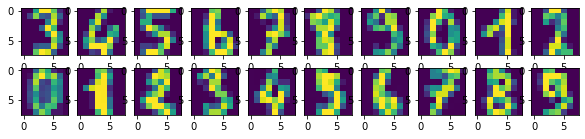

In [81]:
models = [
    #PCA(n_components=10), 
    KernelPCA(n_components=10, fit_inverse_transform=True, kernel="rbf"), 
    #DebiasingKernelPCA(n_components=10, kernel="linear"),
    #DebiasingKernelPCA(n_components=10, kernel="rbf"),
]
N = len(models)+1
def plot_digits(x, N_comparison, n):
    for i in range(10):
        plt.subplot(N_comparison, 10, 1 + n * 10 + i)
        plt.imshow(x[i, :].reshape([8, 8]))

plt.figure(figsize=[10, N])
plot_digits(x_test, N, 0)
for n, model in enumerate(models):
    m = model.fit(x_train)
    x_transformed = m.transform(x_test)
    x_reprojected = m.inverse_transform(x_transformed)
    print("Reprojection Error of {}: {}".format(model.__class__, np.linalg.norm(x_test - x_reprojected)))
    plot_digits(x_reprojected, N, n+1)

# Try the optimization-based pre-imaging

In [82]:
m = DebiasingKernelPCA(n_components=20, kernel=RBF, inv_kernel="rbf")
m.fit(X)
X_tr = m.transform(X)
X_reproj = m.inverse_transform(X_tr)

In [83]:
np.linalg.norm(X-X_reproj)

74.2341533840963

In [84]:
np.linalg.norm(X-X_reproj)

74.2341533840963

In [85]:
x = torch.tensor([[1,2], [3,4.]], requires_grad=True)

#y = torch.sum(x**2) 
#y.backward()
#x.grad

In [86]:
x.reshape(1,2,2)

tensor([[[1., 2.],
         [3., 4.]]], grad_fn=<ViewBackward>)

In [87]:
i = [[0, 1, 1],
     [1, 0, 1]]
v =  [3, 5, 7.]
s = torch.sparse_coo_tensor(i, v, (2, 2))
s.to_dense()

tensor([[0., 3.],
        [5., 7.]])

In [88]:
torch.sparse.mm(s, x)

tensor([[ 9., 12.],
        [26., 38.]], grad_fn=<SparseAddmmBackward>)

In [89]:
torch.sparse.mm(s, x)
s.mm(x)
x.mm(s)

RuntimeError: sparse tensors do not have strides

In [ ]:
f = torch.sum(RBF(x, torch.ones_like(x), grad=True))

In [ ]:
f.backward()

In [ ]:
x.grad

In [ ]:
RBF(x, grad=True)